In [3]:
#%% Libraries import
# import HiDeNN library
import sys  
sys.path.insert(1, '/Users/skardova/Dropbox/Lungs/HiDeNN_1D/hidenn_1d')

from HiDeNN_PDE import MeshNN, NeuROM, MeshNN_2D, MeshNN_1D
# Import pre-processing functions
import Bin.Pre_processing as pre
# Import torch librairies
import torch
import torch.nn as nn
# Import mechanical functions
from Bin.PDE_Library import Strain, Stress,VonMises_plain_strain
# Import Training funcitons
from Bin.Training import Training_2D_FEM
#Import post processing libraries
import Post.Plots as Pplot
import time
import os
import torch._dynamo as dynamo
mps_device = torch.device("mps")
from importlib import reload  # Python 3.4+
import tomllib
import numpy as numpy
import argparse



In [4]:
Default_config_file = '/Users/skardova/Dropbox/Lungs/HiDeNN_1D/hidenn_1d/Configuration/config_2D.toml'

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument('-cf',type=str, help = 'path to the desired configuration file', default=Default_config_file, action = 'store')
    
    args, unknown = parser.parse_known_args()

    inputs = vars(args)
    print(f"* Executing job in {args.cf}")

with open(args.cf, mode="rb") as f:
    config = tomllib.load(f)

* Executing job in /Users/skardova/Dropbox/Lungs/HiDeNN_1D/hidenn_1d/Configuration/config_2D.toml


In [33]:
# Prerequisites
mesh_resolution = [44, 144, 484, 1804, 7088 ]

eval_coord_file = "../2D_example/eval_coordinates.npy"
num_displ_file = "../2D_example/num_solution/num_displacement.npy"
num_VM_stress_file = "../2D_example/num_solution/num_VM_stress.npy"
eval_coord =  torch.tensor(numpy.load(eval_coord_file), dtype=torch.float64, requires_grad=True)
num_displ = torch.tensor(numpy.load(num_displ_file))
num_VM_stress = torch.tensor(numpy.load(num_VM_stress_file))

# Experiment
element_size = [2.0, 1.0, 0.5, 0.25, 0.125]
config["solver"]["FrozenMesh"] = True
optimizers = ["adam","lbfgs"]

error_u = numpy.zeros((len(element_size),len(optimizers)))
error_v = numpy.zeros((len(element_size),len(optimizers)))
error_stress = numpy.zeros((len(element_size),len(optimizers)))
error_stress_max = numpy.zeros((len(element_size),len(optimizers)))

for e in range(len(element_size)):
    config["interpolation"]["MaxElemSize2D"] = element_size[e]
    for op in range(len(optimizers)):
        config["training"]["optimizer"] = optimizers[op]

        Mat = pre.Material(             flag_lame = True,                          # If True should input lmbda and mu instead of E and nu
                                        coef1     = config["material"]["lmbda"],        # Young Modulus
                                        coef2     = config["material"]["mu"]        # Poisson's ratio
                            )

        MaxElemSize = pre.ElementSize(
                                        dimension     = config["interpolation"]["dimension"],
                                        L             = config["geometry"]["L"],
                                        order         = config["interpolation"]["order"],
                                        np            = config["interpolation"]["np"],
                                        MaxElemSize2D = config["interpolation"]["MaxElemSize2D"]
                                    )
        Excluded = []
        Mesh_object = pre.Mesh( 
                                        config["geometry"]["Name"],                 # Create the mesh object
                                        MaxElemSize, 
                                        config["interpolation"]["order"], 
                                        config["interpolation"]["dimension"]
                                )

        Mesh_object.AddBorders(config["Borders"]["Borders"])
        Mesh_object.AddBCs(                                                         # Include Boundary physical domains infos (BCs+volume)
                                        config["geometry"]["Volume_element"],
                                        Excluded,
                                        config["DirichletDictionryList"]
                            )                   

        Mesh_object.MeshGeo()                                                       # Mesh the .geo file if .msh does not exist
        Mesh_object.ReadMesh()                                                      # Parse the .msh file
        Mesh_object.ExportMeshVtk()

        if int(Mesh_object.dim) != int(Mesh_object.dimension):
            raise ValueError("The dimension of the provided geometry does not match the job dimension")

        Model_FEM = MeshNN_2D(Mesh_object, n_components = 2)

        Model_FEM.Freeze_Mesh()
        Model_FEM.UnFreeze_FEM()

        if not config["solver"]["FrozenMesh"]:
            Model_FEM.UnFreeze_Mesh() 

        Model_FEM.RefinementParameters( MaxGeneration = config["training"]["h_adapt_MaxGeneration"], 
                                    Jacobian_threshold = config["training"]["h_adapt_J_thrshld"])

        Model_FEM.TrainingParameters(   loss_decrease_c = config["training"]["loss_decrease_c"], 
                                        Max_epochs = config["training"]["n_epochs"], 
                                        learning_rate = config["training"]["learning_rate"])
        Model_FEM = Training_2D_FEM(Model_FEM, config, Mat)
        
        # evaluation 
        Model_FEM.eval()

        elem_IDs = torch.tensor(Model_FEM.mesh.GetCellIds(eval_coord),dtype=torch.int)
        u = Model_FEM(eval_coord, elem_IDs)
        eps =  Strain(u,eval_coord)
        sigma =  torch.stack(Stress(eps[:,0], eps[:,1], eps[:,2], Mat.lmbda, Mat.mu),dim=1)
        sigma_VM = VonMises_plain_strain(sigma, Mat.lmbda, Mat.mu)

        error_u[e,op] = (torch.linalg.vector_norm(num_displ[:,0] - u[0,:])/torch.linalg.vector_norm(num_displ[:,0])).item()
        error_v[e,op] = (torch.linalg.vector_norm(num_displ[:,1] - u[1,:])/torch.linalg.vector_norm(num_displ[:,1])).item()
        error_stress[e,op] = (torch.linalg.vector_norm(num_VM_stress - sigma_VM)/torch.linalg.vector_norm(num_VM_stress)).item()
        error_stress_max[e,op] = (max(sigma_VM)/max(num_VM_stress)).item()



 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       60
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 6.4658e+00
epoch 500 loss = 1.2127e+00
epoch 1000 loss = 9.4502e-01
epoch 1500 loss = 9.4104e-01
epoch 1543 loss = 9.4103e-01
*************** END FIRST PHASE ***************

* Training time: 7.123976945877075s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.004616964968164015s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       60
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 9.4117e-01
epoch 4 loss = 9.4102e-01
*************** END FIRST PHASE ***************

* Training time: 0.11731600761413574s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.029329001903533936s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       232
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 1.5138e+01
epoch 500 loss = 1.6984e+00
epoch 1000 loss = 8.7944e-01
epoch 1478 loss = 8.7172e-01
*************** END FIRST PHASE ***************

* Training time: 17.23633098602295s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.011661928948594687s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       232
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 9.8282e-01
epoch 5 loss = 8.7171e-01
*************** END FIRST PHASE ***************

* Training time: 0.6018378734588623s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.12036757469177246s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       856
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 2.6950e+01
epoch 500 loss = 2.5079e+00
epoch 1000 loss = 8.5948e-01
epoch 1447 loss = 8.4203e-01
*************** END FIRST PHASE ***************

* Training time: 54.19909477233887s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.03745618159802271s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       856
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 1.4611e+00
epoch 5 loss = 8.4229e-01
epoch 8 loss = 8.4197e-01
*************** END FIRST PHASE ***************

* Training time: 3.654604911804199s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.4568256139755249s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       3384
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 5.3351e+01
epoch 500 loss = 4.3659e+00
epoch 1000 loss = 8.7490e-01
epoch 1500 loss = 8.3269e-01
epoch 1527 loss = 8.3267e-01
*************** END FIRST PHASE ***************

* Training time: 219.1753478050232s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.14353329915194707s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       3384
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 2.9088e+00
epoch 5 loss = 9.5209e-01
epoch 10 loss = 8.3262e-01
epoch 13 loss = 8.3261e-01
*************** END FIRST PHASE ***************

* Training time: 25.575273036956787s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 1.967328695150522s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       13728
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 1.1024e+02
epoch 500 loss = 8.8472e+00
epoch 1000 loss = 1.0318e+00
epoch 1500 loss = 8.4087e-01
epoch 2000 loss = 8.3071e-01
epoch 2101 loss = 8.3043e-01
*************** END FIRST PHASE ***************

* Training time: 1534.3665461540222s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.7303029729433709s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       13728
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 6.7976e+00
epoch 5 loss = 1.4736e+00
epoch 10 loss = 8.7149e-01
epoch 15 loss = 8.3127e-01
epoch 20 loss = 8.3000e-01
epoch 24 loss = 8.3e-01
*************** END FIRST PHASE ***************

* Training time: 245.36585879325867s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 10.22357744971911s


In [34]:
print("Adam")
print("u = ", error_u[:,0])
print("v = ", error_v[:,0])
print("s = ", error_stress[:,0])
print("s max = ", error_stress_max[:,0])
print()
print("LBFGS")
print("u = ", error_u[:,1])
print("v = ", error_v[:,1])
print("s = ", error_stress[:,1])
print("s max = ", error_stress_max[:,1])

Adam
u =  [0.18775588 0.10230352 0.04060538 0.02128754 0.07499295]
v =  [0.02596945 0.01084645 0.00363882 0.00121237 0.00198047]
s =  [0.22971469 0.14722798 0.0826846  0.0434168  0.02648678]
s max =  [0.65595128 0.77592806 0.93797397 0.95504362 0.99851   ]

LBFGS
u =  [0.18588991 0.10080447 0.03665099 0.00976881 0.00178625]
v =  [0.02586959 0.01065384 0.00328927 0.00083952 0.00015972]
s =  [0.22989806 0.14733525 0.08272104 0.04314679 0.02197644]
s max =  [0.65594826 0.77632042 0.93821257 0.95494309 0.99339041]


NameError: name 'error_u' is not defined

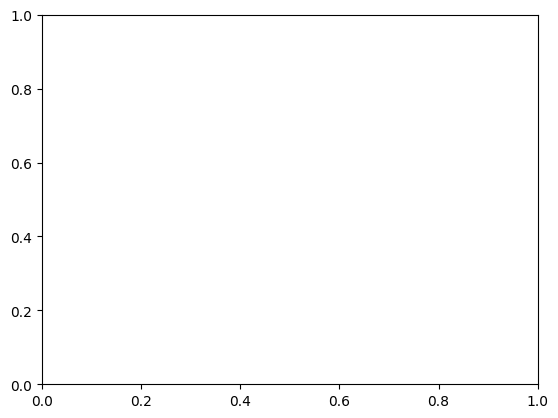

In [2]:
import matplotlib.pyplot as plt
import matplotlib

# Plot normalized displacement error

fig = matplotlib.pyplot.gcf()
ax = plt.gca()

plt.plot(mesh_resolution, error_u[:,0],'--', color = "darkblue", label = r'$\| e_{u_x}\|_2$'+ ", Adam")
plt.plot(mesh_resolution, error_v[:,0],'--', color = "purple", label = r'$\| e_{u_y}\|_2$'+ ", Adam")
plt.plot(mesh_resolution, error_stress[:,0],'--', color = "green", label = r'$\| e_{\sigma_{VM}}\|_2$'+ ", Adam")

plt.plot(mesh_resolution, error_u[:,1],'-', color = "darkblue", label = r'$\| e_{u_x}\|_2$'+ ", L-BFGS")
plt.plot(mesh_resolution, error_v[:,1],'-', color = "purple", label = r'$\| e_{u_y}\|_2$'+ ", L-BFGS")
plt.plot(mesh_resolution, error_stress[:,1],'-', color = "green", label = r'$\| e_{\sigma_{VM}}\|_2$'+ ", L-BFGS")


ax.set_xscale('log')
ax.set_yscale('log')

plt.xlabel("Number of mesh nodes")
plt.ylabel("Normalized displacement error")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False )

plt.show()


In [10]:
# Prerequisites
mesh_resolution = [44, 144, 484, 1804, 7088 ]

eval_coord_file = "../2D_example/eval_coordinates.npy"
num_displ_file = "../2D_example/num_solution/num_displacement.npy"
num_VM_stress_file = "../2D_example/num_solution/num_VM_stress.npy"
eval_coord =  torch.tensor(numpy.load(eval_coord_file), dtype=torch.float64, requires_grad=True)
num_displ = torch.tensor(numpy.load(num_displ_file))
num_VM_stress = torch.tensor(numpy.load(num_VM_stress_file))

# Experiment
element_size = 2.0
config["solver"]["FrozenMesh"] = False
optimizers = ["adam","lbfgs"]
refinment = [1,2,3,4,5]

config["interpolation"]["MaxElemSize2D"] = element_size

r_adapt_error_u = numpy.zeros((len(refinment),len(optimizers)))
r_adapt_error_v = numpy.zeros((len(refinment),len(optimizers)))
r_adapt_error_stress = numpy.zeros((len(refinment),len(optimizers)))
r_adapt_error_stress_max = numpy.zeros((len(refinment),len(optimizers)))

for e in range(len(refinment)):
    config["training"]["multiscl_max_refinment"] = refinment[e]
    for op in range(len(optimizers)):
        config["training"]["optimizer"] = optimizers[op]

        Mat = pre.Material(             flag_lame = True,                          # If True should input lmbda and mu instead of E and nu
                                        coef1     = config["material"]["lmbda"],        # Young Modulus
                                        coef2     = config["material"]["mu"]        # Poisson's ratio
                            )

        MaxElemSize = pre.ElementSize(
                                        dimension     = config["interpolation"]["dimension"],
                                        L             = config["geometry"]["L"],
                                        order         = config["interpolation"]["order"],
                                        np            = config["interpolation"]["np"],
                                        MaxElemSize2D = config["interpolation"]["MaxElemSize2D"]
                                    )
        Excluded = []
        Mesh_object = pre.Mesh( 
                                        config["geometry"]["Name"],                 # Create the mesh object
                                        MaxElemSize, 
                                        config["interpolation"]["order"], 
                                        config["interpolation"]["dimension"]
                                )

        Mesh_object.AddBorders(config["Borders"]["Borders"])
        Mesh_object.AddBCs(                                                         # Include Boundary physical domains infos (BCs+volume)
                                        config["geometry"]["Volume_element"],
                                        Excluded,
                                        config["DirichletDictionryList"]
                            )                   

        Mesh_object.MeshGeo()                                                       # Mesh the .geo file if .msh does not exist
        Mesh_object.ReadMesh()                                                      # Parse the .msh file
        Mesh_object.ExportMeshVtk()

        if int(Mesh_object.dim) != int(Mesh_object.dimension):
            raise ValueError("The dimension of the provided geometry does not match the job dimension")

        Model_FEM = MeshNN_2D(Mesh_object, n_components = 2)

        Model_FEM.Freeze_Mesh()
        Model_FEM.UnFreeze_FEM()

        if not config["solver"]["FrozenMesh"]:
            Model_FEM.UnFreeze_Mesh() 

        Model_FEM.RefinementParameters( MaxGeneration = config["training"]["h_adapt_MaxGeneration"], 
                                    Jacobian_threshold = config["training"]["h_adapt_J_thrshld"])

        Model_FEM.TrainingParameters(   loss_decrease_c = config["training"]["loss_decrease_c"], 
                                        Max_epochs = config["training"]["n_epochs"], 
                                        learning_rate = config["training"]["learning_rate"])
        Model_FEM = Training_2D_FEM(Model_FEM, config, Mat)
        
        # evaluation 
        Model_FEM.eval()

        Model_FEM.mesh.Nodes = [[i+1,Model_FEM.coordinates[i][0][0].item(),Model_FEM.coordinates[i][0][1].item(),0] for i in range(len(Model_FEM.coordinates))]
        Model_FEM.mesh.Connectivity = Model_FEM.connectivity
        Model_FEM.mesh.ExportMeshVtk(flag_update = True)

        elem_IDs = torch.tensor(Model_FEM.mesh.GetCellIds(eval_coord),dtype=torch.int)
        u = Model_FEM(eval_coord, elem_IDs)
        eps =  Strain(u,eval_coord)
        sigma =  torch.stack(Stress(eps[:,0], eps[:,1], eps[:,2], Mat.lmbda, Mat.mu),dim=1)
        sigma_VM = VonMises_plain_strain(sigma, Mat.lmbda, Mat.mu)

        r_adapt_error_u[e,op] = (torch.linalg.vector_norm(num_displ[:,0] - u[0,:])/torch.linalg.vector_norm(num_displ[:,0])).item()
        r_adapt_error_v[e,op] = (torch.linalg.vector_norm(num_displ[:,1] - u[1,:])/torch.linalg.vector_norm(num_displ[:,1])).item()
        r_adapt_error_stress[e,op] = (torch.linalg.vector_norm(num_VM_stress - sigma_VM)/torch.linalg.vector_norm(num_VM_stress)).item()
        r_adapt_error_stress_max[e,op] = (max(sigma_VM)/max(num_VM_stress)).item()



 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       60
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 6.4619e+00
epoch 500 loss = 1.2011e+00
epoch 1000 loss = 9.4127e-01
epoch 1500 loss = 9.3345e-01
epoch 2000 loss = 9.3276e-01
epoch 2500 loss = 9.3240e-01
epoch 3000 loss = 9.3204e-01
epoch 3500 loss = 9.3165e-01
epoch 4000 loss = 9.3127e-01
epoch 4500 loss = 9.3093e-01
epoch 5000 loss = 9.3064e-01
epoch 5500 loss = 9.3043e-01
epoch 6000 loss = 9.3029e-01
epoch 6283 loss = 9.3023e-01
*************** END FIRST PHASE ***************

* Training time: 38.873600006103516s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.006187108070365035s



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       60
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 9.4093e-01
epoch 5 loss = 9.3013e-01
epoch 8 loss = 9.3012e-01
*************** END FIRST PHASE ***************

* Training time: 0.5329530239105225s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.06661912798881531s



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       60
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 6.4619e+00
epoch 500 loss = 1.2011e+00
epoch 1000 loss = 9.4127e-01
epoch 1500 loss = 9.3345e-01
epoch 2000 loss = 9.3276e-01
epoch 2500 loss = 9.3240e-01
epoch 3000 loss = 9.3204e-01
epoch 3500 loss = 9.3165e-01
epoch 4000 loss = 9.3127e-01
epoch 4500 loss = 9.3093e-01
epoch 5000 loss = 9.3064e-01
epoch 5500 loss = 9.3043e-01
epoch 6000 loss = 9.3029e-01
epoch 6283 loss = 9.3023e-01
*************** END FIRST PHASE ***************

* Training time: 39.28170084953308s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.006252061252512029s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elem

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 1

**************** START TRAINING ***************

epoch 2 loss = 8.9251e-01
epoch 500 loss = 8.6037e-01
epoch 1000 loss = 8.5897e-01
epoch 1500 loss = 8.5864e-01
epoch 1519 loss = 8.5863e-01
*************** END FIRST PHASE ***************

* Training time: 22.317355155944824s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.014692136376527205s



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       60
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 9.4093e-01
epoch 5 loss = 9.3013e-01
epoch 8 loss = 9.3012e-01
*************** END FIRST PHASE ***************

* Training time: 0.5154738426208496s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.0644342303276062s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       232
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 1

**************** START TRAINING ***************

epoch 2 loss = 8.6992e-01
epoch 5 loss = 8.6182e-01
epoch 10 loss = 8.5933e-01
epoch 15 loss = 8.5899e-01
epoch 20 loss = 8.5886e-01
epoch 25 loss = 8.5876e-01
epoch 30 loss = 8.5867e-01
epoch 35 loss = 8.5862e-01
epoch 40 loss = 8.5861e-01
epoch 45 loss = 8.5860e-01
epoch 50 loss = 8.5860e-01
epoch 55 loss = 8.586e-01
epoch 60 loss = 8.586e-01
epoch 65 loss = 8.586e-01
epoch 70 loss = 8.5859e-01
epoch 75 loss = 8.5859e-01
epoch 80 loss = 8.5858e-01
epoch 85 loss = 8.5858e-01
epoch 90 loss = 8.5858e-01
epoch 95 loss = 8.5858e-01
epoch 97 loss = 8.5858e-01
*************** END FIRST PHASE ***************

* Training time: 20.149529695510864s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.2077271102629986s



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       60
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 6.4619e+00
epoch 500 loss = 1.2011e+00
epoch 1000 loss = 9.4127e-01
epoch 1500 loss = 9.3345e-01
epoch 2000 loss = 9.3276e-01
epoch 2500 loss = 9.3240e-01
epoch 3000 loss = 9.3204e-01
epoch 3500 loss = 9.3165e-01
epoch 4000 loss = 9.3127e-01
epoch 4500 loss = 9.3093e-01
epoch 5000 loss = 9.3064e-01
epoch 5500 loss = 9.3043e-01
epoch 6000 loss = 9.3029e-01
epoch 6283 loss = 9.3023e-01
*************** END FIRST PHASE ***************

* Training time: 39.59779620170593s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.006302370874057923s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elem

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 1

**************** START TRAINING ***************

epoch 2 loss = 8.9251e-01
epoch 500 loss = 8.6037e-01
epoch 1000 loss = 8.5897e-01
epoch 1500 loss = 8.5864e-01
epoch 1519 loss = 8.5863e-01
*************** END FIRST PHASE ***************

* Training time: 22.82639479637146s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.015027251347183319s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       856
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 2

**************** START TRAINING ***************

epoch 2 loss = 8.4790e-01
epoch 500 loss = 8.3837e-01
epoch 641 loss = 8.381e-01
*************** END FIRST PHASE ***************

* Training time: 30.630398988723755s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.047785333835762486s



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       60
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 9.4093e-01
epoch 5 loss = 9.3013e-01
epoch 8 loss = 9.3012e-01
*************** END FIRST PHASE ***************

* Training time: 0.510004997253418s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.06375062465667725s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       232
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 1

**************** START TRAINING ***************

epoch 2 loss = 8.6992e-01
epoch 5 loss = 8.6182e-01
epoch 10 loss = 8.5933e-01
epoch 15 loss = 8.5899e-01
epoch 20 loss = 8.5886e-01
epoch 25 loss = 8.5876e-01
epoch 30 loss = 8.5867e-01
epoch 35 loss = 8.5862e-01
epoch 40 loss = 8.5861e-01
epoch 45 loss = 8.5860e-01
epoch 50 loss = 8.5860e-01
epoch 55 loss = 8.586e-01
epoch 60 loss = 8.586e-01
epoch 65 loss = 8.586e-01
epoch 70 loss = 8.5859e-01
epoch 75 loss = 8.5859e-01
epoch 80 loss = 8.5858e-01
epoch 85 loss = 8.5858e-01
epoch 90 loss = 8.5858e-01
epoch 95 loss = 8.5858e-01
epoch 97 loss = 8.5858e-01
*************** END FIRST PHASE ***************

* Training time: 20.43373703956604s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.21065708288212412s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 2

**************** START TRAINING ***************

epoch 2 loss = 8.4175e-01
epoch 5 loss = 8.3999e-01
epoch 10 loss = 8.3893e-01
epoch 15 loss = 8.384e-01
epoch 20 loss = 8.3817e-01
epoch 25 loss = 8.3802e-01
epoch 30 loss = 8.3792e-01
epoch 35 loss = 8.3784e-01
epoch 40 loss = 8.3776e-01
epoch 45 loss = 8.3771e-01
epoch 50 loss = 8.3766e-01
epoch 55 loss = 8.3763e-01
epoch 60 loss = 8.3760e-01
epoch 65 loss = 8.3758e-01
epoch 70 loss = 8.3755e-01
epoch 75 loss = 8.3753e-01
epoch 80 loss = 8.3751e-01
epoch 85 loss = 8.3751e-01
epoch 88 loss = 8.3751e-01
*************** END FIRST PHASE ***************

* Training time: 55.84857487678528s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.6346428963271055s



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       60
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 6.4619e+00
epoch 500 loss = 1.2011e+00
epoch 1000 loss = 9.4127e-01
epoch 1500 loss = 9.3345e-01
epoch 2000 loss = 9.3276e-01
epoch 2500 loss = 9.3240e-01
epoch 3000 loss = 9.3204e-01
epoch 3500 loss = 9.3165e-01
epoch 4000 loss = 9.3127e-01
epoch 4500 loss = 9.3093e-01
epoch 5000 loss = 9.3064e-01
epoch 5500 loss = 9.3043e-01
epoch 6000 loss = 9.3029e-01
epoch 6283 loss = 9.3023e-01
*************** END FIRST PHASE ***************

* Training time: 38.5540292263031s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.006136245301019115s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Eleme

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 1

**************** START TRAINING ***************

epoch 2 loss = 8.9251e-01
epoch 500 loss = 8.6037e-01
epoch 1000 loss = 8.5897e-01
epoch 1500 loss = 8.5864e-01
epoch 1519 loss = 8.5863e-01
*************** END FIRST PHASE ***************

* Training time: 22.65997624397278s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.014917693379837248s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       856
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 2

**************** START TRAINING ***************

epoch 2 loss = 8.4790e-01
epoch 500 loss = 8.3837e-01
epoch 641 loss = 8.381e-01
*************** END FIRST PHASE ***************

* Training time: 31.009780883789062s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.0483771932664416s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       3384
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 3

**************** START TRAINING ***************

epoch 2 loss = 8.4366e-01
epoch 409 loss = 8.3184e-01
*************** END FIRST PHASE ***************

* Training time: 79.19961285591125s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.1936420852222769s



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       60
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 9.4093e-01
epoch 5 loss = 9.3013e-01
epoch 8 loss = 9.3012e-01
*************** END FIRST PHASE ***************

* Training time: 0.5166840553283691s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.06458550691604614s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       232
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 1

**************** START TRAINING ***************

epoch 2 loss = 8.6992e-01
epoch 5 loss = 8.6182e-01
epoch 10 loss = 8.5933e-01
epoch 15 loss = 8.5899e-01
epoch 20 loss = 8.5886e-01
epoch 25 loss = 8.5876e-01
epoch 30 loss = 8.5867e-01
epoch 35 loss = 8.5862e-01
epoch 40 loss = 8.5861e-01
epoch 45 loss = 8.5860e-01
epoch 50 loss = 8.5860e-01
epoch 55 loss = 8.586e-01
epoch 60 loss = 8.586e-01
epoch 65 loss = 8.586e-01
epoch 70 loss = 8.5859e-01
epoch 75 loss = 8.5859e-01
epoch 80 loss = 8.5858e-01
epoch 85 loss = 8.5858e-01
epoch 90 loss = 8.5858e-01
epoch 95 loss = 8.5858e-01
epoch 97 loss = 8.5858e-01
*************** END FIRST PHASE ***************

* Training time: 20.465331077575684s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.21098279461418232s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | | 

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 2

**************** START TRAINING ***************

epoch 2 loss = 8.4175e-01
epoch 5 loss = 8.3999e-01
epoch 10 loss = 8.3893e-01
epoch 15 loss = 8.384e-01
epoch 20 loss = 8.3817e-01
epoch 25 loss = 8.3802e-01
epoch 30 loss = 8.3792e-01
epoch 35 loss = 8.3784e-01
epoch 40 loss = 8.3776e-01
epoch 45 loss = 8.3771e-01
epoch 50 loss = 8.3766e-01
epoch 55 loss = 8.3763e-01
epoch 60 loss = 8.3760e-01
epoch 65 loss = 8.3758e-01
epoch 70 loss = 8.3755e-01
epoch 75 loss = 8.3753e-01
epoch 80 loss = 8.3751e-01
epoch 85 loss = 8.3751e-01
epoch 88 loss = 8.3751e-01
*************** END FIRST PHASE ***************

* Training time: 55.845247983932495s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.6346050907265056s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

       

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 3

**************** START TRAINING ***************

epoch 2 loss = 8.3261e-01
epoch 5 loss = 8.3227e-01
epoch 10 loss = 8.3201e-01
epoch 15 loss = 8.3187e-01
epoch 20 loss = 8.3179e-01
epoch 25 loss = 8.3173e-01
epoch 30 loss = 8.3168e-01
epoch 35 loss = 8.3165e-01
epoch 40 loss = 8.3162e-01
epoch 45 loss = 8.316e-01
epoch 50 loss = 8.3158e-01
epoch 55 loss = 8.3156e-01
epoch 60 loss = 8.3154e-01
epoch 65 loss = 8.3153e-01
epoch 70 loss = 8.3152e-01
epoch 75 loss = 8.3150e-01
epoch 80 loss = 8.3149e-01
epoch 85 loss = 8.3148e-01
epoch 90 loss = 8.3147e-01
epoch 95 loss = 8.3146e-01
epoch 100 loss = 8.3145e-01
epoch 105 loss = 8.3145e-01
epoch 110 loss = 8.3144e-01
epoch 115 loss = 8.3143e-01
epoch 120 loss = 8.3142e-01
epoch 125 loss = 8.3142e-01
epoch 130 loss = 8.3141e-01
epoch 135 loss = 8.3141e-01
epoch 140 loss = 8.3140e-01
epoch 145 loss = 8.314e-01
epoch 150 loss = 8.3139e-01
epoch 153 loss = 8.3139e-01
*************** END FIRST PHASE ***************

* Train

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       60
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 6.4619e+00
epoch 500 loss = 1.2011e+00
epoch 1000 loss = 9.4127e-01
epoch 1500 loss = 9.3345e-01
epoch 2000 loss = 9.3276e-01
epoch 2500 loss = 9.3240e-01
epoch 3000 loss = 9.3204e-01
epoch 3500 loss = 9.3165e-01
epoch 4000 loss = 9.3127e-01
epoch 4500 loss = 9.3093e-01
epoch 5000 loss = 9.3064e-01
epoch 5500 loss = 9.3043e-01
epoch 6000 loss = 9.3029e-01
epoch 6283 loss = 9.3023e-01
*************** END FIRST PHASE ***************

* Training time: 39.52613925933838s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.006290965981113859s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elem

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 1

**************** START TRAINING ***************

epoch 2 loss = 8.9251e-01
epoch 500 loss = 8.6037e-01
epoch 1000 loss = 8.5897e-01
epoch 1500 loss = 8.5864e-01
epoch 1519 loss = 8.5863e-01
*************** END FIRST PHASE ***************

* Training time: 23.41855812072754s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.015417088953737682s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       856
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 2

**************** START TRAINING ***************

epoch 2 loss = 8.4790e-01
epoch 500 loss = 8.3837e-01
epoch 641 loss = 8.381e-01
*************** END FIRST PHASE ***************

* Training time: 32.31232213973999s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.05040923890755069s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       3384
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 3

**************** START TRAINING ***************

epoch 2 loss = 8.4366e-01
epoch 409 loss = 8.3184e-01
*************** END FIRST PHASE ***************

* Training time: 82.15986514091492s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.20087986587020762s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       13728
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 4

**************** START TRAINING ***************

epoch 2 loss = 8.9119e-01
epoch 149 loss = 8.2992e-01
*************** END FIRST PHASE ***************

* Training time: 159.87707209587097s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 1.0730004838649059s



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       60
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 9.4093e-01
epoch 5 loss = 9.3013e-01
epoch 8 loss = 9.3012e-01
*************** END FIRST PHASE ***************

* Training time: 0.6561930179595947s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.08202412724494934s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       232
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 1

**************** START TRAINING ***************

epoch 2 loss = 8.6992e-01
epoch 5 loss = 8.6182e-01
epoch 10 loss = 8.5933e-01
epoch 15 loss = 8.5899e-01
epoch 20 loss = 8.5886e-01
epoch 25 loss = 8.5876e-01
epoch 30 loss = 8.5867e-01
epoch 35 loss = 8.5862e-01
epoch 40 loss = 8.5861e-01
epoch 45 loss = 8.5860e-01
epoch 50 loss = 8.5860e-01
epoch 55 loss = 8.586e-01
epoch 60 loss = 8.586e-01
epoch 65 loss = 8.586e-01
epoch 70 loss = 8.5859e-01
epoch 75 loss = 8.5859e-01
epoch 80 loss = 8.5858e-01
epoch 85 loss = 8.5858e-01
epoch 90 loss = 8.5858e-01
epoch 95 loss = 8.5858e-01
epoch 97 loss = 8.5858e-01
*************** END FIRST PHASE ***************

* Training time: 22.562026023864746s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.23259820643159532s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | | 

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 2

**************** START TRAINING ***************

epoch 2 loss = 8.4175e-01
epoch 5 loss = 8.3999e-01
epoch 10 loss = 8.3893e-01
epoch 15 loss = 8.384e-01
epoch 20 loss = 8.3817e-01
epoch 25 loss = 8.3802e-01
epoch 30 loss = 8.3792e-01
epoch 35 loss = 8.3784e-01
epoch 40 loss = 8.3776e-01
epoch 45 loss = 8.3771e-01
epoch 50 loss = 8.3766e-01
epoch 55 loss = 8.3763e-01
epoch 60 loss = 8.3760e-01
epoch 65 loss = 8.3758e-01
epoch 70 loss = 8.3755e-01
epoch 75 loss = 8.3753e-01
epoch 80 loss = 8.3751e-01
epoch 85 loss = 8.3751e-01
epoch 88 loss = 8.3751e-01
*************** END FIRST PHASE ***************

* Training time: 59.99837899208069s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.6817997612736442s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

        

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 3

**************** START TRAINING ***************

epoch 2 loss = 8.3261e-01
epoch 5 loss = 8.3227e-01
epoch 10 loss = 8.3201e-01
epoch 15 loss = 8.3187e-01
epoch 20 loss = 8.3179e-01
epoch 25 loss = 8.3173e-01
epoch 30 loss = 8.3168e-01
epoch 35 loss = 8.3165e-01
epoch 40 loss = 8.3162e-01
epoch 45 loss = 8.316e-01
epoch 50 loss = 8.3158e-01
epoch 55 loss = 8.3156e-01
epoch 60 loss = 8.3154e-01
epoch 65 loss = 8.3153e-01
epoch 70 loss = 8.3152e-01
epoch 75 loss = 8.3150e-01
epoch 80 loss = 8.3149e-01
epoch 85 loss = 8.3148e-01
epoch 90 loss = 8.3147e-01
epoch 95 loss = 8.3146e-01
epoch 100 loss = 8.3145e-01
epoch 105 loss = 8.3145e-01
epoch 110 loss = 8.3144e-01
epoch 115 loss = 8.3143e-01
epoch 120 loss = 8.3142e-01
epoch 125 loss = 8.3142e-01
epoch 130 loss = 8.3141e-01
epoch 135 loss = 8.3141e-01
epoch 140 loss = 8.3140e-01
epoch 145 loss = 8.314e-01
epoch 150 loss = 8.3139e-01
epoch 153 loss = 8.3139e-01
*************** END FIRST PHASE ***************

* Train

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 4

**************** START TRAINING ***************

epoch 2 loss = 8.3e-01
epoch 5 loss = 8.2994e-01
epoch 10 loss = 8.2989e-01
epoch 15 loss = 8.2986e-01
epoch 20 loss = 8.2984e-01
epoch 25 loss = 8.2982e-01
epoch 30 loss = 8.2981e-01
epoch 35 loss = 8.2980e-01
epoch 40 loss = 8.298e-01
epoch 45 loss = 8.2979e-01
epoch 50 loss = 8.2978e-01
epoch 55 loss = 8.2978e-01
epoch 60 loss = 8.2978e-01
epoch 65 loss = 8.2977e-01
epoch 70 loss = 8.2977e-01
epoch 75 loss = 8.2976e-01
epoch 80 loss = 8.2976e-01
epoch 85 loss = 8.2976e-01
epoch 90 loss = 8.2975e-01
epoch 95 loss = 8.2975e-01
epoch 100 loss = 8.2975e-01
epoch 105 loss = 8.2975e-01
epoch 110 loss = 8.2974e-01
epoch 115 loss = 8.2974e-01
epoch 120 loss = 8.2974e-01
epoch 125 loss = 8.2974e-01
epoch 130 loss = 8.2974e-01
epoch 135 loss = 8.2974e-01
epoch 140 loss = 8.2973e-01
epoch 145 loss = 8.2973e-01
epoch 150 loss = 8.2973e-01
epoch 155 loss = 8.2973e-01
epoch 160 loss = 8.2973e-01
epoch 165 loss = 8.2973e-01
ep

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

In [13]:
print("Adam")
print("u = ", r_adapt_error_u[:,0])
print("v = ", r_adapt_error_v[:,0])
print("s = ", r_adapt_error_stress[:,0])
print("s max = ", r_adapt_error_stress_max[:,0])
print()
print("LBFGS")
print("u = ", r_adapt_error_u[:,1])
print("v = ", r_adapt_error_v[:,1])
print("s = ", r_adapt_error_stress[:,1])
print("s max = ", r_adapt_error_stress_max[:,1])


error_u = numpy.zeros((5,len(optimizers)))
error_v = numpy.zeros((5,len(optimizers)))
error_stress = numpy.zeros((5,len(optimizers)))
error_stress_max = numpy.zeros((5,len(optimizers)))

# Adam
error_u[:,0] =          [0.18775588, 0.10230352, 0.04060538, 0.02128754, 0.07499295]
error_v[:,0] =          [0.02596945, 0.01084645, 0.00363882, 0.00121237, 0.00198047]
error_stress[:,0] =     [0.22971469, 0.14722798, 0.0826846,  0.0434168,  0.02648678]
error_stress_max[:,0] = [0.65595128, 0.77592806, 0.93797397, 0.95504362, 0.99851   ]

# LBFGS
error_u[:,1] =          [0.18588991, 0.10080447, 0.03665099, 0.00976881, 0.00178625]
error_v[:,1] =          [0.02586959, 0.01065384, 0.00328927, 0.00083952, 0.00015972]
error_stress[:,1] =     [0.22989806, 0.14733525, 0.08272104, 0.04314679, 0.02197644]
error_stress_max[:,1] = [0.65594826, 0.77632042, 0.93821257, 0.95494309, 0.99339041]

Adam
u =  [0.19446296 0.07558471 0.02454908 0.00849548 0.00761395]
v =  [0.02544193 0.00814626 0.00240292 0.00070402 0.00043606]
s =  [0.2191179  0.11348305 0.06812687 0.03927158 0.02187826]
s max =  [0.68730029 0.87694957 1.00453523 0.99552982 1.01534655]

LBFGS
u =  [0.19647545 0.07507357 0.0238992  0.00623233 0.00087909]
v =  [0.02515144 0.00828193 0.00241225 0.00060402 0.00010286]
s =  [0.21957262 0.11364054 0.06454347 0.0353967  0.01982385]
s max =  [0.68675172 0.87805703 0.95793463 0.99077617 0.99679572]


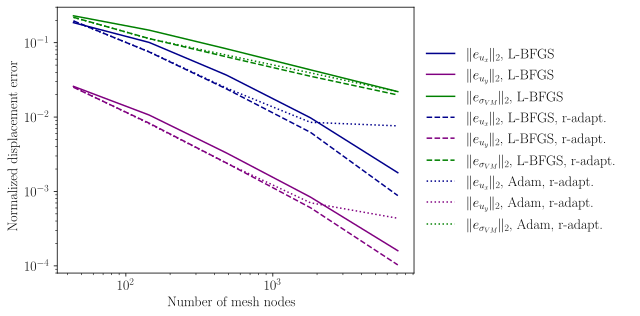

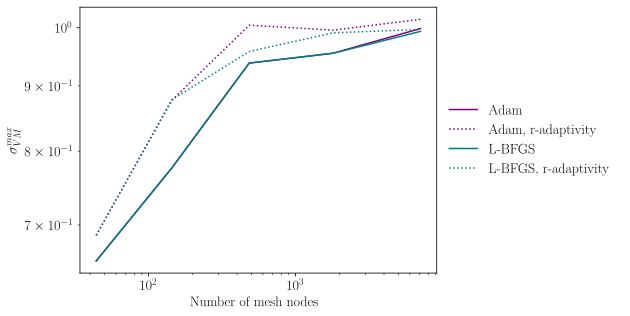

In [34]:
# Plot normalized displacement error

fig = matplotlib.pyplot.gcf()
ax = plt.gca()

plt.plot(mesh_resolution, error_u[:,1],'-', color = "darkblue", label = r'$\| e_{u_x}\|_2$'+ ", L-BFGS")
plt.plot(mesh_resolution, error_v[:,1],'-', color = "purple", label = r'$\| e_{u_y}\|_2$'+ ", L-BFGS")
plt.plot(mesh_resolution, error_stress[:,1],'-', color = "green", label = r'$\| e_{\sigma_{VM}}\|_2$'+ ", L-BFGS")

plt.plot(mesh_resolution, r_adapt_error_u[:,1],'--', color = "darkblue", label = r'$\| e_{u_x}\|_2$'+ ", L-BFGS, r-adapt.")
plt.plot(mesh_resolution, r_adapt_error_v[:,1],'--', color = "purple", label = r'$\| e_{u_y}\|_2$'+ ", L-BFGS, r-adapt.")
plt.plot(mesh_resolution, r_adapt_error_stress[:,1],'--', color = "green", label = r'$\| e_{\sigma_{VM}}\|_2$'+ ", L-BFGS, r-adapt.")

plt.plot(mesh_resolution, r_adapt_error_u[:,0],':', color = "darkblue", label = r'$\| e_{u_x}\|_2$'+ ", Adam, r-adapt.")
plt.plot(mesh_resolution, r_adapt_error_v[:,0],':', color = "purple", label = r'$\| e_{u_y}\|_2$'+ ", Adam, r-adapt.")
plt.plot(mesh_resolution, r_adapt_error_stress[:,0],':', color = "green", label = r'$\| e_{\sigma_{VM}}\|_2$'+ ", Adam, r-adapt.")

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.00008, 0.3])

plt.xlabel("Number of mesh nodes")
plt.ylabel("Normalized displacement error")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False )

plt.show()

# Plot maximal stress

fig = matplotlib.pyplot.gcf()
ax = plt.gca()

plt.plot(mesh_resolution, error_stress_max[:,0],'-', color = "purple", label = "Adam")
plt.plot(mesh_resolution, r_adapt_error_stress_max[:,0],':', color = "purple", label = "Adam, r-adaptivity")
plt.plot(mesh_resolution, error_stress_max[:,1],'-', color = "teal", label = "L-BFGS")
plt.plot(mesh_resolution, r_adapt_error_stress_max[:,1],':', color = "teal", label =  "L-BFGS, r-adaptivity")

ax.set_xscale('log')
ax.set_yscale('log')

plt.xlabel("Number of mesh nodes")
plt.ylabel(r'$\sigma^{max}_{VM}$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False )

plt.show()


In [35]:

# Prerequisites
mesh_resolution = [44, 144, 484, 1804, 7088 ]

eval_coord_file = "../2D_example/eval_coordinates.npy"
num_displ_file = "../2D_example/num_solution/num_displacement.npy"
num_VM_stress_file = "../2D_example/num_solution/num_VM_stress.npy"
eval_coord =  torch.tensor(numpy.load(eval_coord_file), dtype=torch.float64, requires_grad=True)
num_displ = torch.tensor(numpy.load(num_displ_file))
num_VM_stress = torch.tensor(numpy.load(num_VM_stress_file))

# Experiment
element_size = 2.0
config["solver"]["FrozenMesh"] = False
optimizer = "lbfgs"
refinment = [1,2,3,4,5]

config["interpolation"]["MaxElemSize2D"] = element_size
config["training"]["optimizer"] = optimizer
config["training"]["h_adapt_MaxGeneration"] = 3

rh_adapt_error_u = numpy.zeros((len(refinment)))
rh_adapt_error_v = numpy.zeros((len(refinment)))
rh_adapt_error_stress = numpy.zeros((len(refinment)))
rh_adapt_error_stress_max = numpy.zeros((len(refinment)))

for e in range(len(refinment)):
    config["training"]["multiscl_max_refinment"] = refinment[e]

    Mat = pre.Material(             flag_lame = True,                          # If True should input lmbda and mu instead of E and nu
                                    coef1     = config["material"]["lmbda"],        # Young Modulus
                                    coef2     = config["material"]["mu"]        # Poisson's ratio
                        )

    MaxElemSize = pre.ElementSize(
                                    dimension     = config["interpolation"]["dimension"],
                                    L             = config["geometry"]["L"],
                                    order         = config["interpolation"]["order"],
                                    np            = config["interpolation"]["np"],
                                    MaxElemSize2D = config["interpolation"]["MaxElemSize2D"]
                                )
    Excluded = []
    Mesh_object = pre.Mesh( 
                                    config["geometry"]["Name"],                 # Create the mesh object
                                    MaxElemSize, 
                                    config["interpolation"]["order"], 
                                    config["interpolation"]["dimension"]
                            )

    Mesh_object.AddBorders(config["Borders"]["Borders"])
    Mesh_object.AddBCs(                                                         # Include Boundary physical domains infos (BCs+volume)
                                    config["geometry"]["Volume_element"],
                                    Excluded,
                                    config["DirichletDictionryList"]
                        )                   

    Mesh_object.MeshGeo()                                                       # Mesh the .geo file if .msh does not exist
    Mesh_object.ReadMesh()                                                      # Parse the .msh file
    Mesh_object.ExportMeshVtk()

    if int(Mesh_object.dim) != int(Mesh_object.dimension):
        raise ValueError("The dimension of the provided geometry does not match the job dimension")

    Model_FEM = MeshNN_2D(Mesh_object, n_components = 2)

    Model_FEM.Freeze_Mesh()
    Model_FEM.UnFreeze_FEM()

    if not config["solver"]["FrozenMesh"]:
        Model_FEM.UnFreeze_Mesh() 

    Model_FEM.RefinementParameters( MaxGeneration = config["training"]["h_adapt_MaxGeneration"], 
                                Jacobian_threshold = config["training"]["h_adapt_J_thrshld"])

    Model_FEM.TrainingParameters(   loss_decrease_c = config["training"]["loss_decrease_c"], 
                                    Max_epochs = config["training"]["n_epochs"], 
                                    learning_rate = config["training"]["learning_rate"])
    Model_FEM = Training_2D_FEM(Model_FEM, config, Mat)
    
    # evaluation 
    Model_FEM.eval()

    Model_FEM.mesh.Nodes = [[i+1,Model_FEM.coordinates[i][0][0].item(),Model_FEM.coordinates[i][0][1].item(),0] for i in range(len(Model_FEM.coordinates))]
    Model_FEM.mesh.Connectivity = Model_FEM.connectivity
    Model_FEM.mesh.ExportMeshVtk(flag_update = True)

    elem_IDs = torch.tensor(Model_FEM.mesh.GetCellIds(eval_coord),dtype=torch.int)
    u = Model_FEM(eval_coord, elem_IDs)
    eps =  Strain(u,eval_coord)
    sigma =  torch.stack(Stress(eps[:,0], eps[:,1], eps[:,2], Mat.lmbda, Mat.mu),dim=1)
    sigma_VM = VonMises_plain_strain(sigma, Mat.lmbda, Mat.mu)

    rh_adapt_error_u[e] = (torch.linalg.vector_norm(num_displ[:,0] - u[0,:])/torch.linalg.vector_norm(num_displ[:,0])).item()
    rh_adapt_error_v[e] = (torch.linalg.vector_norm(num_displ[:,1] - u[1,:])/torch.linalg.vector_norm(num_displ[:,1])).item()
    rh_adapt_error_stress[e] = (torch.linalg.vector_norm(num_VM_stress - sigma_VM)/torch.linalg.vector_norm(num_VM_stress)).item()
    rh_adapt_error_stress_max[e] = (max(sigma_VM)/max(num_VM_stress)).item()



 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       60
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 9.4093e-01
epoch 5 loss = 9.3013e-01
epoch 10 loss = 9.1573e-01
epoch 15 loss = 9.1467e-01
epoch 20 loss = 9.1443e-01
epoch 25 loss = 9.1356e-01
epoch 30 loss = 9.1198e-01
epoch 35 loss = 9.1049e-01
epoch 40 loss = 9.0982e-01
epoch 45 loss = 9.0559e-01
epoch 50 loss = 9.0456e-01
epoch 55 loss = 9.0207e-01
epoch 60 loss = 8.9915e-01
epoch 65 loss = 8.9760e-01
epoch 70 loss = 8.9678e-01
epoch 75 loss = 8.9622e-01
epoch 80 loss = 8.9569e-01
epoch 85 loss = 8.9312e-01
epoch 90 loss = 8.9275e-01
epoch 95 loss = 8.9255e-01
epoch 100 loss = 8.924e-01
epoch 105 loss = 8.9227e-01
epoch 107 loss = 8.9227e-01
*************** END FIRST PHASE ***************

* Training time: 21.12073802947998s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.19739007504186898s



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       60
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 9.4093e-01
epoch 5 loss = 9.3013e-01
epoch 10 loss = 9.1573e-01
epoch 15 loss = 9.1467e-01
epoch 20 loss = 9.1443e-01
epoch 25 loss = 9.1356e-01
epoch 30 loss = 9.1198e-01
epoch 35 loss = 9.1049e-01
epoch 40 loss = 9.0982e-01
epoch 45 loss = 9.0559e-01
epoch 50 loss = 9.0456e-01
epoch 55 loss = 9.0207e-01
epoch 60 loss = 8.9915e-01
epoch 65 loss = 8.9760e-01
epoch 70 loss = 8.9678e-01
epoch 75 loss = 8.9622e-01
epoch 80 loss = 8.9569e-01
epoch 85 loss = 8.9312e-01
epoch 90 loss = 8.9275e-01
epoch 95 loss = 8.9255e-01
epoch 100 loss = 8.924e-01
epoch 105 loss = 8.9227e-01
epoch 107 loss = 8.9227e-01
*************** END FIRST PHASE ***************

* Training time: 20.066993713378906s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.1875419973212982s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | 

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 1

**************** START TRAINING ***************

epoch 2 loss = 8.6654e-01
epoch 5 loss = 8.6043e-01
epoch 10 loss = 8.5767e-01
epoch 15 loss = 8.5648e-01
epoch 20 loss = 8.5471e-01
epoch 25 loss = 8.5368e-01
epoch 30 loss = 8.5290e-01
epoch 35 loss = 8.5257e-01
epoch 40 loss = 8.5201e-01
epoch 45 loss = 8.5184e-01
epoch 50 loss = 8.5164e-01
epoch 55 loss = 8.5152e-01
epoch 60 loss = 8.5136e-01
epoch 65 loss = 8.5119e-01
epoch 70 loss = 8.5097e-01
epoch 75 loss = 8.5082e-01
epoch 80 loss = 8.5074e-01
epoch 85 loss = 8.5069e-01
epoch 90 loss = 8.5058e-01
epoch 95 loss = 8.5052e-01
epoch 100 loss = 8.505e-01
epoch 105 loss = 8.5043e-01
epoch 110 loss = 8.5039e-01
epoch 115 loss = 8.5036e-01
epoch 120 loss = 8.5035e-01
epoch 121 loss = 8.5035e-01
*************** END FIRST PHASE ***************

* Training time: 42.46916079521179s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.35098479996042803s



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       60
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 9.4093e-01
epoch 5 loss = 9.3013e-01
epoch 10 loss = 9.1573e-01
epoch 15 loss = 9.1467e-01
epoch 20 loss = 9.1443e-01
epoch 25 loss = 9.1356e-01
epoch 30 loss = 9.1198e-01
epoch 35 loss = 9.1049e-01
epoch 40 loss = 9.0982e-01
epoch 45 loss = 9.0559e-01
epoch 50 loss = 9.0456e-01
epoch 55 loss = 9.0207e-01
epoch 60 loss = 8.9915e-01
epoch 65 loss = 8.9760e-01
epoch 70 loss = 8.9678e-01
epoch 75 loss = 8.9622e-01
epoch 80 loss = 8.9569e-01
epoch 85 loss = 8.9312e-01
epoch 90 loss = 8.9275e-01
epoch 95 loss = 8.9255e-01
epoch 100 loss = 8.924e-01
epoch 105 loss = 8.9227e-01
epoch 107 loss = 8.9227e-01
*************** END FIRST PHASE ***************

* Training time: 19.567131996154785s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.1828703924874279s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | 

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 1

**************** START TRAINING ***************

epoch 2 loss = 8.6654e-01
epoch 5 loss = 8.6043e-01
epoch 10 loss = 8.5767e-01
epoch 15 loss = 8.5648e-01
epoch 20 loss = 8.5471e-01
epoch 25 loss = 8.5368e-01
epoch 30 loss = 8.5290e-01
epoch 35 loss = 8.5257e-01
epoch 40 loss = 8.5201e-01
epoch 45 loss = 8.5184e-01
epoch 50 loss = 8.5164e-01
epoch 55 loss = 8.5152e-01
epoch 60 loss = 8.5136e-01
epoch 65 loss = 8.5119e-01
epoch 70 loss = 8.5097e-01
epoch 75 loss = 8.5082e-01
epoch 80 loss = 8.5074e-01
epoch 85 loss = 8.5069e-01
epoch 90 loss = 8.5058e-01
epoch 95 loss = 8.5052e-01
epoch 100 loss = 8.505e-01
epoch 105 loss = 8.5043e-01
epoch 110 loss = 8.5039e-01
epoch 115 loss = 8.5036e-01
epoch 120 loss = 8.5035e-01
epoch 121 loss = 8.5035e-01
*************** END FIRST PHASE ***************

* Training time: 42.34933018684387s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.3499944643540816s
 
 
   _   _      

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 2

**************** START TRAINING ***************

epoch 2 loss = 8.4163e-01
epoch 5 loss = 8.3984e-01
epoch 10 loss = 8.3878e-01
epoch 15 loss = 8.3837e-01
epoch 20 loss = 8.3786e-01
epoch 25 loss = 8.3767e-01
epoch 30 loss = 8.3750e-01
epoch 35 loss = 8.3735e-01
epoch 40 loss = 8.3727e-01
epoch 45 loss = 8.3719e-01
epoch 50 loss = 8.3712e-01
epoch 55 loss = 8.3703e-01
epoch 60 loss = 8.3695e-01
epoch 65 loss = 8.3692e-01
epoch 70 loss = 8.3683e-01
epoch 75 loss = 8.3680e-01
epoch 80 loss = 8.3673e-01
epoch 85 loss = 8.3669e-01
epoch 90 loss = 8.3665e-01
epoch 95 loss = 8.3662e-01
epoch 100 loss = 8.366e-01
epoch 105 loss = 8.366e-01
epoch 110 loss = 8.3659e-01
epoch 115 loss = 8.3657e-01
epoch 120 loss = 8.3653e-01
epoch 125 loss = 8.3651e-01
epoch 130 loss = 8.3649e-01
epoch 135 loss = 8.3647e-01
epoch 140 loss = 8.3644e-01
*************** END FIRST PHASE ***************

* Training time: 115.9721269607544s
* Saving time: 0s
* Evaluation time: 0s
* Backward time

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       60
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 9.4093e-01
epoch 5 loss = 9.3013e-01
epoch 10 loss = 9.1573e-01
epoch 15 loss = 9.1467e-01
epoch 20 loss = 9.1443e-01
epoch 25 loss = 9.1356e-01
epoch 30 loss = 9.1198e-01
epoch 35 loss = 9.1049e-01
epoch 40 loss = 9.0982e-01
epoch 45 loss = 9.0559e-01
epoch 50 loss = 9.0456e-01
epoch 55 loss = 9.0207e-01
epoch 60 loss = 8.9915e-01
epoch 65 loss = 8.9760e-01
epoch 70 loss = 8.9678e-01
epoch 75 loss = 8.9622e-01
epoch 80 loss = 8.9569e-01
epoch 85 loss = 8.9312e-01
epoch 90 loss = 8.9275e-01
epoch 95 loss = 8.9255e-01
epoch 100 loss = 8.924e-01
epoch 105 loss = 8.9227e-01
epoch 107 loss = 8.9227e-01
*************** END FIRST PHASE ***************

* Training time: 19.208504915237427s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.17951873752558342s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ |

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 1

**************** START TRAINING ***************

epoch 2 loss = 8.6654e-01
epoch 5 loss = 8.6043e-01
epoch 10 loss = 8.5767e-01
epoch 15 loss = 8.5648e-01
epoch 20 loss = 8.5471e-01
epoch 25 loss = 8.5368e-01
epoch 30 loss = 8.5290e-01
epoch 35 loss = 8.5257e-01
epoch 40 loss = 8.5201e-01
epoch 45 loss = 8.5184e-01
epoch 50 loss = 8.5164e-01
epoch 55 loss = 8.5152e-01
epoch 60 loss = 8.5136e-01
epoch 65 loss = 8.5119e-01
epoch 70 loss = 8.5097e-01
epoch 75 loss = 8.5082e-01
epoch 80 loss = 8.5074e-01
epoch 85 loss = 8.5069e-01
epoch 90 loss = 8.5058e-01
epoch 95 loss = 8.5052e-01
epoch 100 loss = 8.505e-01
epoch 105 loss = 8.5043e-01
epoch 110 loss = 8.5039e-01
epoch 115 loss = 8.5036e-01
epoch 120 loss = 8.5035e-01
epoch 121 loss = 8.5035e-01
*************** END FIRST PHASE ***************

* Training time: 41.87775993347168s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.3460971895328238s
 
 
   _   _      

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 2

**************** START TRAINING ***************

epoch 2 loss = 8.4163e-01
epoch 5 loss = 8.3984e-01
epoch 10 loss = 8.3878e-01
epoch 15 loss = 8.3837e-01
epoch 20 loss = 8.3786e-01
epoch 25 loss = 8.3767e-01
epoch 30 loss = 8.3750e-01
epoch 35 loss = 8.3735e-01
epoch 40 loss = 8.3727e-01
epoch 45 loss = 8.3719e-01
epoch 50 loss = 8.3712e-01
epoch 55 loss = 8.3703e-01
epoch 60 loss = 8.3695e-01
epoch 65 loss = 8.3692e-01
epoch 70 loss = 8.3683e-01
epoch 75 loss = 8.3680e-01
epoch 80 loss = 8.3673e-01
epoch 85 loss = 8.3669e-01
epoch 90 loss = 8.3665e-01
epoch 95 loss = 8.3662e-01
epoch 100 loss = 8.366e-01
epoch 105 loss = 8.366e-01
epoch 110 loss = 8.3659e-01
epoch 115 loss = 8.3657e-01
epoch 120 loss = 8.3653e-01
epoch 125 loss = 8.3651e-01
epoch 130 loss = 8.3649e-01
epoch 135 loss = 8.3647e-01
epoch 140 loss = 8.3644e-01
*************** END FIRST PHASE ***************

* Training time: 113.35913610458374s
* Saving time: 0s
* Evaluation time: 0s
* Backward tim

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 3

**************** START TRAINING ***************

epoch 2 loss = 8.3259e-01
epoch 5 loss = 8.3225e-01
epoch 10 loss = 8.3205e-01
epoch 15 loss = 8.3192e-01
epoch 20 loss = 8.3181e-01
epoch 25 loss = 8.3167e-01
epoch 30 loss = 8.3162e-01
epoch 35 loss = 8.3157e-01
epoch 40 loss = 8.3152e-01
epoch 45 loss = 8.3148e-01
epoch 50 loss = 8.3145e-01
epoch 55 loss = 8.3141e-01
epoch 60 loss = 8.3138e-01
epoch 65 loss = 8.3135e-01
epoch 70 loss = 8.3134e-01
epoch 75 loss = 8.3132e-01
epoch 80 loss = 8.3131e-01
epoch 85 loss = 8.3129e-01
epoch 90 loss = 8.3128e-01
epoch 95 loss = 8.3126e-01
epoch 100 loss = 8.3125e-01
epoch 105 loss = 8.3124e-01
epoch 110 loss = 8.3123e-01
epoch 115 loss = 8.3122e-01
epoch 120 loss = 8.3121e-01
epoch 125 loss = 8.3121e-01
epoch 130 loss = 8.3120e-01
epoch 135 loss = 8.3119e-01
epoch 140 loss = 8.3118e-01
epoch 145 loss = 8.3117e-01
epoch 150 loss = 8.3116e-01
epoch 155 loss = 8.3115e-01
epoch 160 loss = 8.3114e-01
epoch 165 loss = 8.3113e-0

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ | | | |_) | | | | |\/| |
  | |\  |  __/ |_| |  _ <| |_| | |  | |
  |_| \_|\___|\__,_|_| \_\ ___/|_|  |_|

                  v2.0.2

************ MESH READING COMPLETE ************

 * Dimension of the problem: 2D
 * Elements type:            t3: 3-node triangle
 * Number of Elements:       60
 * No excluded points:          True



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 0

**************** START TRAINING ***************

epoch 2 loss = 9.4093e-01
epoch 5 loss = 9.3013e-01
epoch 10 loss = 9.1573e-01
epoch 15 loss = 9.1467e-01
epoch 20 loss = 9.1443e-01
epoch 25 loss = 9.1356e-01
epoch 30 loss = 9.1198e-01
epoch 35 loss = 9.1049e-01
epoch 40 loss = 9.0982e-01
epoch 45 loss = 9.0559e-01
epoch 50 loss = 9.0456e-01
epoch 55 loss = 9.0207e-01
epoch 60 loss = 8.9915e-01
epoch 65 loss = 8.9760e-01
epoch 70 loss = 8.9678e-01
epoch 75 loss = 8.9622e-01
epoch 80 loss = 8.9569e-01
epoch 85 loss = 8.9312e-01
epoch 90 loss = 8.9275e-01
epoch 95 loss = 8.9255e-01
epoch 100 loss = 8.924e-01
epoch 105 loss = 8.9227e-01
epoch 107 loss = 8.9227e-01
*************** END FIRST PHASE ***************

* Training time: 19.098719120025635s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.17849270205631435s
 
 
   _   _            ____   ___  __  __ 
  | \ | | ___ _   _|  _ \ / _ \|  \/  |
  |  \| |/ _ \ |

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 1

**************** START TRAINING ***************

epoch 2 loss = 8.6654e-01
epoch 5 loss = 8.6043e-01
epoch 10 loss = 8.5767e-01
epoch 15 loss = 8.5648e-01
epoch 20 loss = 8.5471e-01
epoch 25 loss = 8.5368e-01
epoch 30 loss = 8.5290e-01
epoch 35 loss = 8.5257e-01
epoch 40 loss = 8.5201e-01
epoch 45 loss = 8.5184e-01
epoch 50 loss = 8.5164e-01
epoch 55 loss = 8.5152e-01
epoch 60 loss = 8.5136e-01
epoch 65 loss = 8.5119e-01
epoch 70 loss = 8.5097e-01
epoch 75 loss = 8.5082e-01
epoch 80 loss = 8.5074e-01
epoch 85 loss = 8.5069e-01
epoch 90 loss = 8.5058e-01
epoch 95 loss = 8.5052e-01
epoch 100 loss = 8.505e-01
epoch 105 loss = 8.5043e-01
epoch 110 loss = 8.5039e-01
epoch 115 loss = 8.5036e-01
epoch 120 loss = 8.5035e-01
epoch 121 loss = 8.5035e-01
*************** END FIRST PHASE ***************

* Training time: 41.77227783203125s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 0.3452254366283574s
 
 
   _   _      

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 2

**************** START TRAINING ***************

epoch 2 loss = 8.4163e-01
epoch 5 loss = 8.3984e-01
epoch 10 loss = 8.3878e-01
epoch 15 loss = 8.3837e-01
epoch 20 loss = 8.3786e-01
epoch 25 loss = 8.3767e-01
epoch 30 loss = 8.3750e-01
epoch 35 loss = 8.3735e-01
epoch 40 loss = 8.3727e-01
epoch 45 loss = 8.3719e-01
epoch 50 loss = 8.3712e-01
epoch 55 loss = 8.3703e-01
epoch 60 loss = 8.3695e-01
epoch 65 loss = 8.3692e-01
epoch 70 loss = 8.3683e-01
epoch 75 loss = 8.3680e-01
epoch 80 loss = 8.3673e-01
epoch 85 loss = 8.3669e-01
epoch 90 loss = 8.3665e-01
epoch 95 loss = 8.3662e-01
epoch 100 loss = 8.366e-01
epoch 105 loss = 8.366e-01
epoch 110 loss = 8.3659e-01
epoch 115 loss = 8.3657e-01
epoch 120 loss = 8.3653e-01
epoch 125 loss = 8.3651e-01
epoch 130 loss = 8.3649e-01
epoch 135 loss = 8.3647e-01
epoch 140 loss = 8.3644e-01
*************** END FIRST PHASE ***************

* Training time: 113.09468412399292s
* Saving time: 0s
* Evaluation time: 0s
* Backward tim

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 3

**************** START TRAINING ***************

epoch 2 loss = 8.3259e-01
epoch 5 loss = 8.3225e-01
epoch 10 loss = 8.3205e-01
epoch 15 loss = 8.3192e-01
epoch 20 loss = 8.3181e-01
epoch 25 loss = 8.3167e-01
epoch 30 loss = 8.3162e-01
epoch 35 loss = 8.3157e-01
epoch 40 loss = 8.3152e-01
epoch 45 loss = 8.3148e-01
epoch 50 loss = 8.3145e-01
epoch 55 loss = 8.3141e-01
epoch 60 loss = 8.3138e-01
epoch 65 loss = 8.3135e-01
epoch 70 loss = 8.3134e-01
epoch 75 loss = 8.3132e-01
epoch 80 loss = 8.3131e-01
epoch 85 loss = 8.3129e-01
epoch 90 loss = 8.3128e-01
epoch 95 loss = 8.3126e-01
epoch 100 loss = 8.3125e-01
epoch 105 loss = 8.3124e-01
epoch 110 loss = 8.3123e-01
epoch 115 loss = 8.3122e-01
epoch 120 loss = 8.3121e-01
epoch 125 loss = 8.3121e-01
epoch 130 loss = 8.3120e-01
epoch 135 loss = 8.3119e-01
epoch 140 loss = 8.3118e-01
epoch 145 loss = 8.3117e-01
epoch 150 loss = 8.3116e-01
epoch 155 loss = 8.3115e-01
epoch 160 loss = 8.3114e-01
epoch 165 loss = 8.3113e-0

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

* Refinement level: 4

**************** START TRAINING ***************

epoch 2 loss = 8.3e-01
epoch 5 loss = 8.2994e-01
epoch 10 loss = 8.2990e-01
epoch 15 loss = 8.2987e-01
epoch 20 loss = 8.2986e-01
epoch 25 loss = 8.2984e-01
epoch 30 loss = 8.2981e-01
epoch 35 loss = 8.2979e-01
epoch 40 loss = 8.2978e-01
epoch 45 loss = 8.2977e-01
epoch 50 loss = 8.2977e-01
epoch 55 loss = 8.2976e-01
epoch 60 loss = 8.2976e-01
epoch 65 loss = 8.2975e-01
epoch 69 loss = 8.2975e-01
*************** END FIRST PHASE ***************

* Training time: 1129.8237907886505s
* Saving time: 0s
* Evaluation time: 0s
* Backward time: 0s
* Update time: 0s
* Average epoch time: 16.374257837516673s



Warning: VTK ASCII files are only meant for debugging.

Warning: DOLFIN XML is a legacy format. Consider using XDMF instead.

In [36]:
print("LBFGS")
print("u = ", rh_adapt_error_u[:,1])
print("v = ", rh_adapt_error_v[:,1])
print("s = ", rh_adapt_error_stress[:,1])
print("s max = ", rh_adapt_error_stress_max[:,1])


LBFGS
u =  [0.11227244 0.0537129  0.01984346 0.00694631 0.00175945]
v =  [0.01554563 0.00556161 0.00196447 0.0005783  0.00016194]
s =  [0.1387024  0.09069215 0.05998508 0.03307471 0.021129  ]
s max =  [0.899737   0.97754178 1.01654283 1.00790708 0.97778525]


(5, 2)


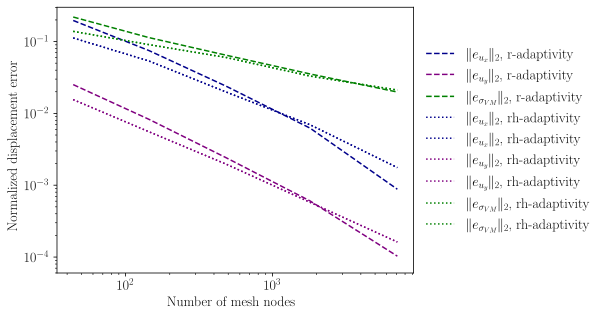

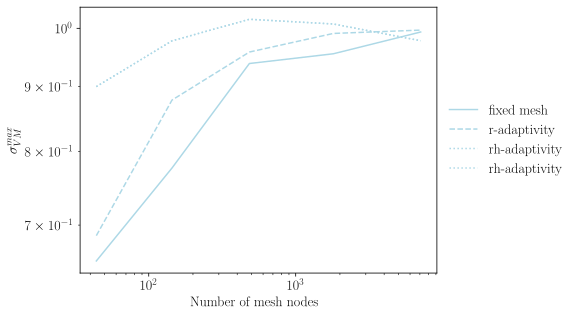

In [52]:
# Plot normalized displacement error

fig = matplotlib.pyplot.gcf()
ax = plt.gca()

print(rh_adapt_error_u.shape)

plt.plot(mesh_resolution, r_adapt_error_u[:,1],'--', color = "darkblue", label = r'$\| e_{u_x}\|_2$'+ ", r-adaptivity")
plt.plot(mesh_resolution, r_adapt_error_v[:,1],'--', color = "purple", label = r'$\| e_{u_y}\|_2$'+ ", r-adaptivity")
plt.plot(mesh_resolution, r_adapt_error_stress[:,1],'--', color = "green", label = r'$\| e_{\sigma_{VM}}\|_2$'+ ", r-adaptivity")

plt.plot(mesh_resolution, rh_adapt_error_u,':', color = "darkblue", label = r'$\| e_{u_x}\|_2$'+ ", rh-adaptivity")
plt.plot(mesh_resolution, rh_adapt_error_v,':', color = "purple", label = r'$\| e_{u_y}\|_2$'+ ", rh-adaptivity")
plt.plot(mesh_resolution, rh_adapt_error_stress,':', color = "green", label = r'$\| e_{\sigma_{VM}}\|_2$'+ ", rh-adaptivity")


ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([0.00006, 0.3])

plt.xlabel("Number of mesh nodes")
plt.ylabel("Normalized displacement error")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False )

plt.show()

# Plot maximal stress

fig = matplotlib.pyplot.gcf()
ax = plt.gca()

plt.plot(mesh_resolution, error_stress_max[:,1],'-', color = "lightblue", label = "fixed mesh")
plt.plot(mesh_resolution, r_adapt_error_stress_max[:,1],'--', color = "lightblue", label =  "r-adaptivity")
plt.plot(mesh_resolution, rh_adapt_error_stress_max,':', color = "lightblue", label =  "rh-adaptivity")

ax.set_xscale('log')
ax.set_yscale('log')

plt.xlabel("Number of mesh nodes")
plt.ylabel(r'$\sigma^{max}_{VM}$')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False )

plt.show()
